In [2]:
import envirVariables as datasetPath

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = datasetPath.giveDatasetPath()
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display summary statistics
print(df.describe())


       Date        AMZN        DPZ         BTC       NFLX
0  5/1/2013  248.229996  51.190983  106.250000  30.415714
1  5/2/2013  252.550003  51.987320   98.099998  30.641428
2  5/3/2013  258.049988  52.446388  112.900002  30.492857
3  5/6/2013  255.720001  53.205257  109.599998  30.098572
4  5/7/2013  257.730011  54.151505  113.199997  29.464285
              AMZN          DPZ           BTC         NFLX
count  1520.000000  1520.000000   1520.000000  1520.000000
mean    821.541810   146.771695   2421.465669   147.668273
std     518.442653    72.192287   3310.894199   107.641486
min     248.229996    51.190983     69.660004    29.464285
25%     364.360001    84.993593    340.904999    62.851071
50%     686.459992   127.168053    625.304993   104.000000
75%    1121.287536   202.454994   3874.912415   192.207496
max    2039.510010   298.635986  18972.320310   418.970001


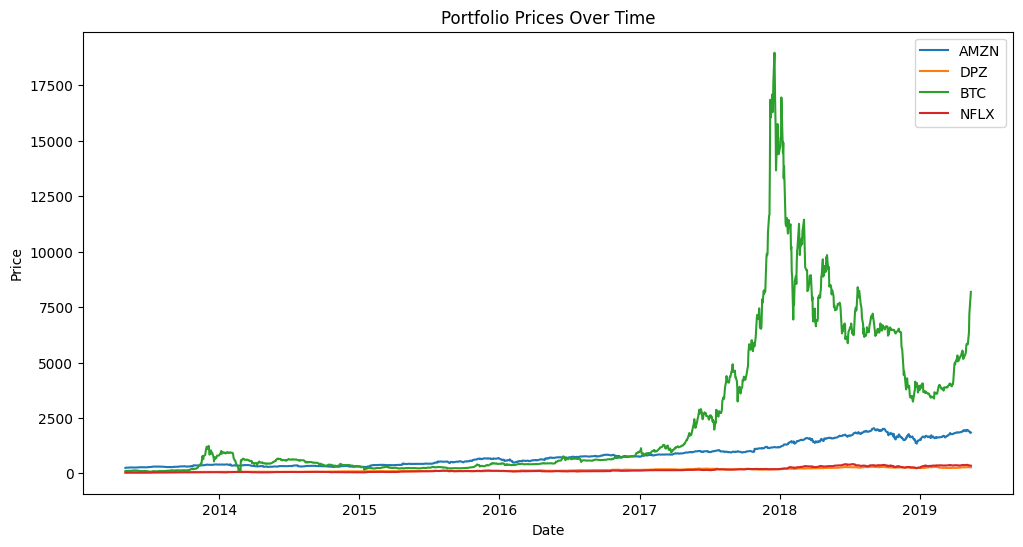

In [3]:
# Plot each asset's closing price
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df[column], label=column)
plt.title('Portfolio Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


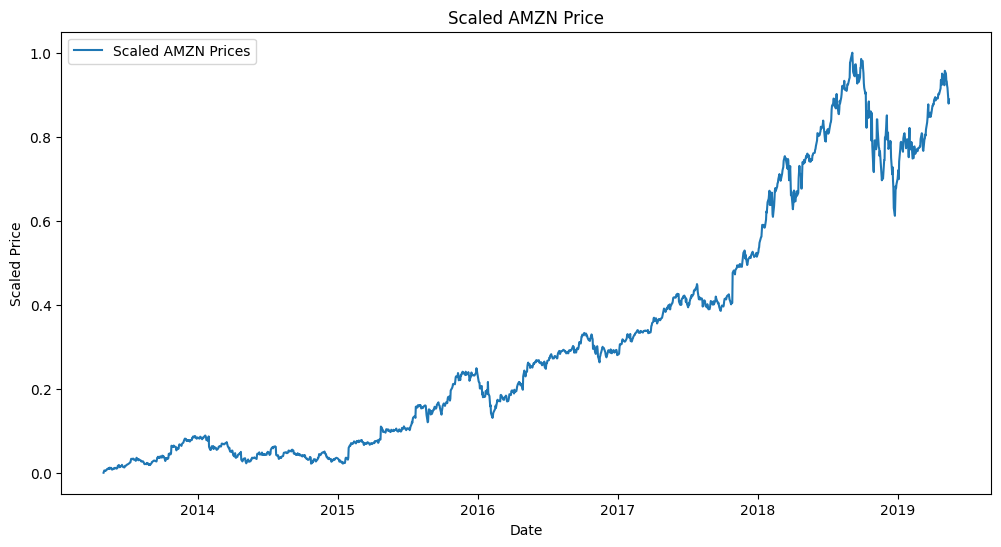

In [4]:
# Select the column for prediction (e.g., 'AMZN')
asset = 'AMZN'
data = df[[asset]]

# Scale the data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert to DataFrame for visualization
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=[asset])

# Plot the scaled data
plt.figure(figsize=(12, 6))
plt.plot(scaled_df, label=f'Scaled {asset} Prices')
plt.title(f'Scaled {asset} Price')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


In [6]:
import numpy as np


# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Set the sequence length
sequence_length = 50  # Using the past 50 days to predict the next day

# Prepare data for training
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X for LSTM (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")


Training samples: (1176, 50, 1), Testing samples: (294, 50, 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)


C:\Users\Pranav\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0234 - val_loss: 0.0037
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 3.5193e-04 - val_loss: 0.0049
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 1.9057e-04 - val_loss: 0.0027
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.9760e-04 - val_loss: 0.0035
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.7868e-04 - val_loss: 0.0030
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0444e-04 - val_loss: 0.0032
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.2388e-04 - val_loss: 0.0022
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.6883e-04 - val_loss: 0.0024
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.9135e-04 - val_loss: 0.0028
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.5144e-04 - val_loss: 0.0016


In [ ]:
# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Actual values for comparison
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title(f'Actual vs Predicted {asset} Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
